In [1]:
# THIS CELL SETS STUFF UP FOR DEMO / COLLAB. THIS CELL CAN BE IGNORED.

#-------------------------------------GET RID OF TF DEPRECATION WARNINGS--------------------------------------#
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#----------------------------------INSTALL PSYCHRNN IF IN A COLAB NOTEBOOK-------------------------------------#
# Installs the correct branch / release version based on the URL. If no branch is provided, loads from master.
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import json
    import re
    import ipykernel
    import requests 
    from requests.compat import urljoin

    from notebook.notebookapp import list_running_servers
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path'].split('%2F')
                if 'blob' in relative_path:
                  blob = relative_path[relative_path.index('blob') + 1]
                  !pip install git+https://github.com/murraylab/PsychRNN@$blob
                else:
                  !pip install git+https://github.com/murraylab/PsychRNN

# Define New Model

Defining a new model requires some familiarity with tensorflow. In this case, we add a feedforward input layer to the [Basic RNN](../apidoc/backend.rst#psychrnn.backend.models.basic.Basic). Because we have added a new weight matrix, we need to modify our initialization. We then must define what a [forward_pass](../apidoc/backend.rst#psychrnn.backend.rnn.RNN.forward_pass) for the model looks like.

## init
We define the feedforward weight matrix, W_in_first to have ``'N_feedforward_out'`` outputs and ``'N_in'`` inputs. We must thus change W_in and input_connectivity to have ``'N_feedforward_out'`` inputs. Optionally, users can pass in keys for ``'N_feedforward_out'`` and ``'W_in_first_train'`` in the params dictionary. 

We call ``super(RNN, self).__init__`` so that all the initialization work done by [RNN](../apidoc/backend.rst#psychrnn.backend.rnn.RNN) carries over.

All modified or added matrices are put into ``initializer.initializations`` and initialized in our variable scope.

## forward_pass
``forward_pass()`` iterates through the network, one timepoint at a time. For each timepoint the output and state is recorded added to an array that will be returned. The output and state are calculated using ``recurrent_timestep()`` and ``output_timestep()``.

### output_timestep
``output_timestep()`` takes the state and calculates the output. ``output_timestep()`` is the same as in [Basic RNN](../apidoc/backend.rst#psychrnn.backend.models.basic.Basic.output_timestep).

### recurrent_timestep
``recurrent_timestep()`` takes the state and input and calculates the next state. This is where the feedforward layer is added, as processed input. The remainder of the function is the same as in [Basic RNN](../apidoc/backend.rst#psychrnn.backend.models.basic.Basic.recurrent_timestep)


In [2]:
from __future__ import division

from psychrnn.backend.rnn import RNN
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np

class Basic_with_Feedforward(RNN):
    """ The basic recurrent neural network model.

    Basic implementation of :class:`psychrnn.backend.rnn.RNN` with a simple RNN.
    Input goes through a feedforward layer before being passed to the recurrent part of the RNN.
    Biological constraints are enabled.

    Args:
       params (dict): See :class:`psychrnn.backend.rnn.RNN` for details.
            Additional Dictionary Keys:
                N_feedforward_out (int, optional): Number of outputs from the feedforward input layer. Default: 32
                W_in_first_train (bool, optional): True if feedforward weights, W_in_first, are trainable. Default: True

    """
    
    def __init__(self, params):
        
        self.N_feedforward_out = params.get('N_feedforward_out', 32)
        self.W_in_first_train = params.get('W_in_first_train', True)
        
        super(Basic_with_Feedforward, self).__init__(params)
        
        self.initializer.initializations['W_in_first'] = params.get('W_in_first', self.initializer.rand_init(np.ones((self.N_feedforward_out, self.N_in))))
        
        self.initializer.initializations['feedforward_input_connectivity'] = params.get('feedforward_input_connectivity', np.ones(( self.N_rec, self.N_feedforward_out)))
        
        self.initializer.initializations['feedforward_W_in'] = params.get('feedforward_W_in', self.initializer.rand_init(np.ones(( self.N_rec, self.N_feedforward_out))))
        
        with tf.compat.v1.variable_scope(self.name) as scope:
            # Input weight matrix:
            self.W_in_first = \
                tf.compat.v1.get_variable('W_in_first', [self.N_feedforward_out, self.N_in],
                                initializer=self.initializer.get('W_in_first'),
                                trainable=self.W_in_first_train)
            
            self.input_connectivity = tf.compat.v1.get_variable('feedforward_input_connectivity', [self.N_rec, self.N_feedforward_out],
                                                      initializer=self.initializer.get('feedforward_input_connectivity'),
                                                      trainable=False)
            
            self.W_in = \
                tf.compat.v1.get_variable('feedforward_W_in', [self.N_rec, self.N_feedforward_out],
                                initializer=self.initializer.get('feedforward_W_in'),
                                trainable=self.W_in_train)

    def recurrent_timestep(self, rnn_in, state):
        """ Recurrent time step.

        Given input and previous state, outputs the next state of the network.

        Arguments:
            rnn_in (*tf.Tensor(dtype=float, shape=(?*, :attr:`N_in` *))*): Input to the rnn at a certain time point.
            state (*tf.Tensor(dtype=float, shape=(* :attr:`N_batch` , :attr:`N_rec` *))*): State of network at previous time point.

        Returns:
            new_state (*tf.Tensor(dtype=float, shape=(* :attr:`N_batch` , :attr:`N_rec` *))*): New state of the network.

        """
        processed_input = self.transfer_function(tf.matmul(rnn_in, self.W_in_first, transpose_b=True, name="3"))
        
        new_state = ((1-self.alpha) * state) \
                    + self.alpha * (
                        tf.matmul(
                            self.transfer_function(state),
                            self.get_effective_W_rec(),
                            transpose_b=True, name="1")
                        + tf.matmul(
                            processed_input,
                            self.get_effective_W_in(),
                            transpose_b=True, name="2")
                        + self.b_rec)\
                    + tf.sqrt(2.0 * self.alpha * self.rec_noise * self.rec_noise)\
                      * tf.random.normal(tf.shape(input=state), mean=0.0, stddev=1.0)

        return new_state

    def output_timestep(self, state):
        """ Output timestep.

        Given the state, what is the output of the network?

        Arguments:
            state (*tf.Tensor(dtype=float, shape=(* :attr:`N_batch` , :attr:`N_rec` *))*): State of network at a given timepoint for each trial in the batch.

        Returns:
            output (*tf.Tensor(dtype=float, shape=(* :attr:`N_batch` , :attr:`N_out` *))*): Output of the network at a given timepoint for each trial in the batch.

        """
     
        output = tf.matmul(self.transfer_function(state),
                                self.get_effective_W_out(), transpose_b=True, name="3") \
                    + self.b_out
     
        return output

    def forward_pass(self):

        """ Run the RNN on a batch of task inputs.

        Iterates over timesteps, running the :func:`recurrent_timestep` and :func:`output_timestep`

        Implements :func:`psychrnn.backend.rnn.RNN.forward_pass`.

        Returns:
            tuple:
            * **predictions** (*tf.Tensor(*:attr:`N_batch`, :attr:`N_steps`, :attr:`N_out` *))*) -- Network output on inputs found in self.x within the tf network.
            * **states** (*tf.Tensor(*:attr:`N_batch`, :attr:`N_steps`, :attr:`N_rec` *))*) -- State variable values over the course of the trials found in self.x within the tf network.

        """

        rnn_inputs = tf.unstack(self.x, axis=1)
        state = self.init_state
        rnn_outputs = []
        rnn_states = []
        for rnn_input in rnn_inputs:
            state = self.recurrent_timestep(rnn_input, state)
            output = self.output_timestep(state)
            rnn_outputs.append(output)
            rnn_states.append(state)
        return tf.transpose(a=rnn_outputs, perm=[1, 0, 2]), tf.transpose(a=rnn_states, perm=[1, 0, 2])

Iter 1280, Minibatch Loss= 0.128628
Iter 2560, Minibatch Loss= 0.095538
Iter 3840, Minibatch Loss= 0.089444
Iter 5120, Minibatch Loss= 0.085808
Iter 6400, Minibatch Loss= 0.082073
Iter 7680, Minibatch Loss= 0.073270
Iter 8960, Minibatch Loss= 0.059777
Iter 10240, Minibatch Loss= 0.035830
Iter 11520, Minibatch Loss= 0.025013
Iter 12800, Minibatch Loss= 0.031894
Iter 14080, Minibatch Loss= 0.072593
Iter 15360, Minibatch Loss= 0.038075
Iter 16640, Minibatch Loss= 0.027692
Iter 17920, Minibatch Loss= 0.025687
Iter 19200, Minibatch Loss= 0.031069
Iter 20480, Minibatch Loss= 0.020855
Iter 21760, Minibatch Loss= 0.012131
Iter 23040, Minibatch Loss= 0.015565
Iter 24320, Minibatch Loss= 0.012561
Iter 25600, Minibatch Loss= 0.012876
Iter 26880, Minibatch Loss= 0.018462
Iter 28160, Minibatch Loss= 0.015606
Iter 29440, Minibatch Loss= 0.009202
Iter 30720, Minibatch Loss= 0.016933
Iter 32000, Minibatch Loss= 0.011563
Iter 33280, Minibatch Loss= 0.014158
Iter 34560, Minibatch Loss= 0.014100
Iter 358

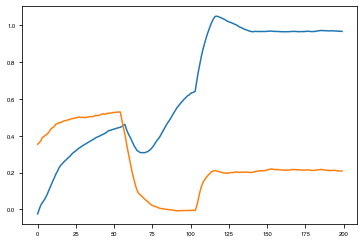

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

# ---------------------- Import the package ---------------------------
from psychrnn.tasks.perceptual_discrimination import PerceptualDiscrimination
from psychrnn.backend.models.basic import Basic

# ---------------------- Set up a basic model ---------------------------
pd = PerceptualDiscrimination(dt = 10, tau = 100, T = 2000, N_batch = 128)
network_params = pd.get_task_params() # get the params passed in and defined in pd
network_params['name'] = 'model' # name the model uniquely if running mult models in unison
network_params['N_rec'] = 50 # set the number of recurrent units in the model
model = Basic_with_Feedforward(network_params) # instantiate a basic vanilla RNN

# ---------------------- Train a basic model ---------------------------
model.train(pd) # train model to perform pd task

# ---------------------- Test the trained model ---------------------------
x,target_output,mask, trial_params = pd.get_trial_batch() # get pd task inputs and outputs
model_output, model_state = model.test(x) # run the model on input x

# ---------------------- Plot the results ---------------------------
plt.plot(model.test(x)[0][0,:,:])

# ---------------------- Teardown the model -------------------------
model.destruct()

# Further Extensibility -- Initializations, Loss Functions, and Regularizations

If you wish to modify weight initializations you must define an initialization class describing your preferred initial weight patterns that inherits from [WeightInitializer](../apidoc/backend.rst#psychrnn.backend.initializations.WeightInitializer) or one of it's child classes. 

If you wish to modify loss functions or regularizations you must define a function and pass that function into the RNN as part of the RNN's params. See [LossFunction](../apidoc/backend.rst#psychrnn.backend.loss_functions.LossFunction) and [Regularizer](../apidoc/backend.rst#psychrnn.backend.regularizations.Regularizer) respectively for details.